# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

**Datasets:** GitHub Issues Dataset https://www.kaggle.com/datasets/davidshinn/github-issues?resource=download

---

# 01 Exploration Data Analysis

## Objective
Explore and clean the data to prepare it for model training in the next phase.

## Notebook Goals
1. Load and inspect the dataset.
2. Understand column types and distribution.
3. Handle missing values and duplicates.
4. Clean and normalize text fields (tokenization, stopwords, lemmatization).
5. Prepare a clean dataset for feature extraction and modeling

## Imports and Setup

In [1]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import langid
from sklearn.feature_extraction.text import TfidfVectorizer

# Export precessed DataFrame
import joblib

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Data

In [2]:
def load_data_sample(filename, n_sample=25000, chunksize=50000, random_state=42):
  """
  Samples n_sample rows from a large CSV without loading the full file into memory.

  Args:
      filename (str): path to CSV file
      n_sample (int, optional): Number of rows to sample. Defaults to 25000.
      chunksize (int, optional): Number of rows to read at a time. Defaults to 50000.
      random_state (int, optional): For reproducibility. Defaults to 42.
  """
  
  sampled_rows = []
  
  for chunk in pd.read_csv(filename, chunksize=chunksize):
    # Fraction to sample from current chunk
    frac = n_sample / len(chunk)
    sampled_rows.append(chunk.sample(frac=min(1, frac), random_state=random_state))
    
  sampled_df = pd.concat(sampled_rows).sample(n=n_sample, random_state=random_state).reset_index(drop=True)
  
  return sampled_df

In [ ]:
# Github Issues
git_issues_filename = "../../data/raw/github_issues.csv"

git_issues_df = load_data_sample(git_issues_filename, n_sample=50000)
print("Github Issues shape: ", git_issues_df.shape)

Github Issues shape:  (90000, 3)


### Data Exploration

In [20]:
# Removing issue_url column for privacy
git_issues_df = git_issues_df.drop(columns=['issue_url'])

KeyError: "['issue_url'] not found in axis"

In [21]:
git_issues_df.head()

,issue_title,body
0,i can't reset the user agent,"after i installed randomua i can't download some add-ons from amo since amo now thinks i use firefox 52. i tried excluding addons.mozilla.org didn't work , setting the minimum spoofer version to 5..."
1,long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...
2,raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...
3,tab key not working for any function on mac,mojira ticket mc-334 https://bugs.mojang.com/browse/mc-334 <img src= https://secure.gravatar.com/avatar/c73b06d0f7d78154de104f2e546091db?d=mm&s=24 width=20 height=20> newell ellis https://bugs.moj...
4,first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_..."


In [22]:
git_issues_df.tail()

,issue_title,body
89995,make the default code example for dotty compile,"http://www.scala-lang.org/blog/2017/05/31/first-dotty-milestone-release.html links to https://scastie.scala-lang.org/?target=dotty which by default contains: scala list hello , world .mkstring , ,..."
89996,"distributed multi-gpu training -- hangs for certain batch_size, epoch_number combinations.","i am running a distributed training job over 2 p2.x8large instances. when i set the batch_size to be 256 and run for 4 epochs, over a record that has ~6000 images, the main thread hangs. however, ..."
89997,user can start their car.,motivation we want to be able to start the movement of the cars. tasks - create instructions for starting the car. - create a method that starts the car. - create an event listener that starts the...
89998,q2pro.menu fix binds and server's search,"hi, i am writting a q2pro.menu for dday mod. and there is some shout, who change every time with alias. the sound change every time when you push on a key. so here, i am writting the key binding i..."
89999,column headings are repeating for every sub cat. in download,"in the downloads for categories with sub-cats the download is repeating the column headers for each sub cat. also, the results number is including the sub-header. need to take that out."


In [23]:
git_issues_df.info()
git_issues_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issue_title  90000 non-null  object
 1   body         90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


,issue_title,body
count,90000,90000
unique,86734,87389
top,first from flow in uk south,first from flow in uk south
freq,1486,1486


In [24]:
stop_words = set(stopwords.words('english'))  # removes stopwords
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  """
  Cleans and preprocess text

  Args:
      text (str): The text that gets cleaned
  """
  
  text = str(text).lower()
  text = text.replace('_', ' ')
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # removes urls
  text = re.sub(r"[^a-z0-9\s]", "", text)               # removes punctuation
  tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
  return " ".join(tokens)

In [25]:
# Create new label by combining issue_title and body
combined_text = git_issues_df['issue_title'].fillna('') + ' ' + git_issues_df['body'].fillna('')
git_issues_df['clean_text'] = combined_text.apply(clean_text)

git_issues_df.head()

,issue_title,body,clean_text
0,i can't reset the user agent,"after i installed randomua i can't download some add-ons from amo since amo now thinks i use firefox 52. i tried excluding addons.mozilla.org didn't work , setting the minimum spoofer version to 5...",cant reset user agent installed randomua cant download addons amo since amo think use firefox 52 tried excluding addonsmozillaorg didnt work setting minimum spoofer version 53 didnt work deactivat...
1,long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...,long string input commandline fail long string input commandline cause failure string long filename truncate text long input creating filename add option specify filename
2,raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...,raster simulation rendering lw4 raster displaysimulate quirk lw4 huge improvement lw3 appreciative volunteer work gone contribute code paid nothing use program right criticism therefore intended c...
3,tab key not working for any function on mac,mojira ticket mc-334 https://bugs.mojang.com/browse/mc-334 <img src= https://secure.gravatar.com/avatar/c73b06d0f7d78154de104f2e546091db?d=mm&s=24 width=20 height=20> newell ellis https://bugs.moj...,tab key working function mac mojira ticket mc334 img src width20 height20 newell elli oct 24 2012 mac tab key anything ex player list autofinish command player list key bound another key player li...
4,first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_...",first reading adc without adc start adc temperaturecpp temperaturecpp version 11x 20 fuction void temperatureisr static adcsensorstate adc sensor state startupdelay cpp switch adc sensor state tem...


## Handling missing values and duplicates

In [26]:
git_issues_df.isna().sum()

issue_title    0
body           0
clean_text     0
dtype: int64

In [27]:
duplicates = git_issues_df[git_issues_df.duplicated(subset='body', keep=False)]
print("Number of duplicate rows: ", duplicates.shape[0])

Number of duplicate rows:  2980


In [28]:
duplicates[['issue_title', 'body']].head(10)

,issue_title,body
11,missing card: -coin token set by ball,check if this card's info exists in deckdata.js
20,please add me - champs-sur-marne,hello! :wave: please add me as a collaborator to this repo.
36,first from flow in uk south,first from flow in uk south
40,first from flow in uk south,first from flow in uk south
54,first from flow in uk south,first from flow in uk south
57,first from flow in uk south,first from flow in uk south
63,contribute to the kill list,"to add a bit of a personal touch, add a programmer grievance of your own to the kill_list.md file."
64,first from flow in uk south,first from flow in uk south
95,tutorial page del.md issue. test blue,tutorial issue found: https://github.com/alenapetsyeva/alenatut/blob/master/tutorials/for del/del.md https://github.com/alenapetsyeva/alenatut/blob/master/tutorials/for%20del/del.md contains inval...
121,missing card: -coin token set by bridge troll,check if this card's info exists in deckdata.js


In [29]:
# Removing duplicate but keeping first occurrance
git_issues_df = git_issues_df.drop_duplicates(subset='body', keep='first')
print("Dataset shape after removing duplicates: ", git_issues_df.shape)

Dataset shape after removing duplicates:  (87389, 3)


In [30]:
# Check for outliers in text size
git_issues_df["word_count"] = git_issues_df["clean_text"].apply(lambda x: len(x.split()))
git_issues_df.sort_values(by='word_count', ascending=False).head()

C:\Users\rusty\AppData\Local\Temp\ipykernel_11360\3646199530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  git_issues_df["word_count"] = git_issues_df["clean_text"].apply(lambda x: len(x.split()))


,issue_title,body,clean_text,word_count
48178,章节 1.2 基本思路 有 bug,"按文章所讲，写出的代码为 java for int i = 1; i <= n; i++ { for int j = w i - 1 ; j <= w; j++ { f i j = math.max f i - 1 j - w i - 1 + v i - 1 , f i - 1 j ; } } 输出： 0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\...",12 bug java int 1 n int j w 1 j w j f j mathmax f 1 j w 1 v 1 f 1 j 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 60 60 ...,466
9497,utiliser le hardware du google home avec jarvis,"bonjour, voici l'idée : j'ai jeedom sur un nuc dans mon sous-sol. je voudrais jarvis au r+1 dans mon salon. les solutions : rallonge usb je pense pas , bluetooth même avec la la super clé bluetoot...",utiliser le hardware du google home avec jarvis bonjour voici lide jai jeedom sur un nuc dans mon soussol je voudrais jarvis au r1 dans mon salon le solution rallonge usb je pense pa bluetooth mme...,291
76986,errores al insertar contenidos con mediawidget,"buenas, estuve probando el plugin para insertar contenido dentro del texto y hay varios errores, pero depende mucho del navegador que se use el error es uno u otro con s.o. debian 8 / firefox 45.6...",errores al insertar contenidos con mediawidget buenas estuve probando el plugin para insertar contenido dentro del texto hay varios errores pero depende mucho del navegador que se use el error e u...,288
32060,fix new main,pour ceux que ca interesse moi par exemple voici selon moi la liste des choses a fix sur le new main : - x mettre des <errno.h> - x renvoyer 0 si eof + string vide - rebase sur master - si isatty ...,fix new main pour ceux que ca interesse moi par exemple voici selon moi la liste de choses fix sur le new main x mettre de errnoh x renvoyer 0 si eof string vide rebase sur master si isatty fail r...,265
7882,stuck at opencl 0: 99%,i am running ubuntu 16.04.1 with kernel 4.8.0-54-generic. when i start the mining client it gets stuck at opencl 0: 99% and just hangs there. i have the latest amdgpu drivers for a r9 290x gpu. 00...,stuck opencl 0 99 running ubuntu 16041 kernel 48054generic start mining client get stuck opencl 0 99 hang latest amdgpu driver r9 290x gpu 00000 host bridge intel corporation xeon e31200 v23rd gen...,264


In [31]:
# Remove outlier
git_issues_df = git_issues_df[git_issues_df['word_count'] < 300]
git_issues_df.shape

(87388, 4)

In [32]:
# Check for non-english text
def label_english(text):
  try:
    text = str(text).strip()
    if len(text.split()) < 20:
      return 'unknown'
    return 'english' if langid.classify(text)[0] == 'en' else 'unknown'
  except:
    return 'unknown'

git_issues_df['lang'] = git_issues_df['clean_text'].apply(label_english)

In [33]:
git_issues_df['lang'].value_counts()

lang
english    55822
unknown    31566
Name: count, dtype: int64

In [34]:
# remove all non-english rows
git_issues_df = git_issues_df[git_issues_df['lang'] == 'english']
git_issues_df['lang'].value_counts()

lang
english    55822
Name: count, dtype: int64

## Challenge: Missing Priority Labels

one key challenge with the GitHub Issues dataset is that it **does not contain explicit priority or severity labels** (e.g., Critical, High, Medium, Low).

- **Impact:** Without a target variable, a supervised machine learning model cannot directly learn to classify issues by priority.
- **Common in real-word data:** Many open-source and internal issue trackers do not consistently label bugs with priority. This is a realistic scenario or software teams.

#### Solution: Weak Supervision via NLP

To address this, I will generate **pseudo-labels** for priority using **keyword-based NLP heuristics** on the issue text (`issue_title + body`):

- Define priority-related keywords for each class (Critical, High, Medium, Low).
- Assign the highest matching priority found in the text to each issue.
- Treat these derived labels as training targets for the ML model.

> Note: These labels are noisy approximations, but they allow me to **demonstrate the end-to-end ML pipeline** (text preprocessing -> feature extraction -> classification -> evaluation) in a realistic setting. Future work could involve human-labeled data or more sophisticated weak supervision techniques.

In [35]:
# Rule-based heuristic classifier
def assign_priority(text):
  text = str(text).lower()
  
  keywords = {
    "Critical": [
      "crash", "urgent", "block", "security", "data loss", "immediate", "leak", 
      "vulnerability", "malware", "corrupt", "unusable", "fatal", "system down",
      "cannot start", "inaccessible", "critical failure", "no access", "breach", 
      "exploit", "does not start", "infinite loop", "freeze system", "freezes"
      ],
    "High": [
      "fail", "error", "exception", "bug", "does not load", "timeout", "service down",
      "not working", "unable to", "stuck", "timeout", "incorrect", "wrong output",
      "not responding", "malfunction", "breaks", "regression", "unhandled",
      "unexpected", "missing file", "authentication", "deployment issue", "api error"
      ],
    "Medium": [
      "slow", "warning", "minor", "performance", "degraded", "inconsistent",
      "optimization", "delay", "unreliable", "resource usage", "partial failure",
      "sometimes", "temporary issue", "reduces performance", "fine-tuning", "occasionally",
      "lag", "refactor", "intermittent", "unreliable", "deprecated", "update", "load time"
      ],
    "Low": [
      "typo", "cosmetic", "suggestion", "enhancement", "refactor", "documentation",
      "readme", "cleanup", "alignment", "spacing", "grammar", "style", "formatting",
      "ui polish", "code comment", "naming", "color", "minor ui", "ui", "comment",
      "spelling", "non-critical", "translation", "ux", "improve"
      ]
  }
  
  for priority, words in keywords.items():
    if any(word in text for word in words):
      return priority
    
  return None

In [36]:
git_issues_df["priority"] = git_issues_df["clean_text"].apply(assign_priority)
git_issues_df.columns

Index(['issue_title', 'body', 'clean_text', 'word_count', 'lang', 'priority'], dtype='object')

In [37]:
git_issues_df["priority"].value_counts(dropna=False)

priority
None        17656
High        17555
Low          9866
Critical     5552
Medium       5193
Name: count, dtype: int64

In [38]:
git_issues_df.shape

(55822, 6)

In [50]:
git_issues_df = git_issues_df[git_issues_df['priority'].notna()].copy()
git_issues_df["priority"].value_counts(dropna=False)

priority
High        17555
Low          9866
Critical     5552
Medium       5193
Name: count, dtype: int64

In [51]:
git_issues_df.shape

(38166, 6)

In [52]:
processed_df = git_issues_df[['issue_title', 'body', 'clean_text', 'priority']].copy()
print(processed_df.shape)

(38166, 4)


In [53]:
print(processed_df['priority'].value_counts)

<bound method IndexOpsMixin.value_counts of 1          High
2           Low
4        Medium
7          High
10         High
          ...  
89979      High
89985      High
89988      High
89990      High
89995    Medium
Name: priority, Length: 38166, dtype: object>


In [54]:
v = TfidfVectorizer(
  stop_words='english',
  max_features=10000,
  ngram_range=(1, 2),
  min_df=5,
  max_df=0.9
)
X = v.fit_transform(processed_df['clean_text'])
y = processed_df['priority']

In [55]:
all_feature_names = v.get_feature_names_out()

for word in all_feature_names:
  indx = v.vocabulary_.get(word)
  if v.idf_[indx] < 4:
    print(f"{word} {v.idf_[indx]}")

10 3.930002333111968
able 3.9187799660041787
actual 3.826164074616668
add 3.107903662503177
app 3.8230728820469952
behavior 3.751203493269432
bug 3.1810333637968444
build 3.330131092717558
case 3.660267397490114
change 3.3615931323841597
check 3.6483491931020224
class 3.90672291133392
code 2.8724574076317655
command 3.7710963995688283
create 3.5855708280537004
current 3.6961217337968013
currently 3.76483725123954
data 3.5776054179729826
default 3.795244999424255
description 3.807758647073953
doesnt 3.5500479673951877
dont 3.486663635567846
error 2.302186733929349
example 3.2853632171629705
expected 3.223209716655109
failed 3.8160429761187373
feature 3.6476090006181905
file 2.6361762664009634
fix 3.7165225982535803
following 3.21741819467552
function 3.49679351009707
help 3.584180973764646
hi 3.588007730913273
id 3.605234382962479
im 3.135674114397914
image 3.789259517681217
information 3.615213083012375
install 3.9418484736161306
instead 3.6561544733897358
issue 2.5567961943849045
know

## Data Visualization

In [56]:
idf_df = pd.DataFrame({'word': all_feature_names, 'idf': v.idf_})

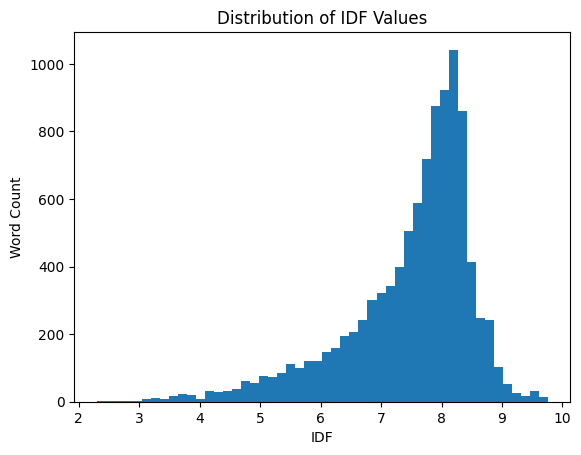

In [57]:
plt.hist(idf_df['idf'], bins=50)
plt.title("Distribution of IDF Values")
plt.xlabel("IDF")
plt.ylabel("Word Count")
plt.show()

## Analysis: Distribution of IDF Values

The histogram of IDF (Inverse Document Frequency) values provides insight into the rarity and informativeness of words in the GitHub Issues dataset:

- **Ramp up to ~8:** Most words have moderate IDF values, indicating they appear in multiple issues but are not overly common. These are generally informative words that help distiguish between issues of different priorities.

- **Drop at ~9:** Very few words reach extremely high IDF values. These represent rare or unique words, such as variable names, unique identifiers, or typos, which appear in only a handful of issues.

**Implications for feature selection:**
- Words with very low IDF (frequent across many documents) are typically stopwords or non-informative terms and can be safely ignored.
- Words with very high IDF (extremely rare) may introduce noise and sparsity, so capping or filtering them can improve model efficiency without sacrificing predictive power.

**Conclusion:**
The distribution suggests a well-balanced vocabulary for TF-IDF feature extraction, with a good mix of moderately frequent informative words and a small number of extremely rare tokens.

In [58]:
threshold = np.percentile(idf_df['idf'], 10) # bottom 10%
common_words = idf_df[idf_df['idf'] <= threshold].sort_values('idf', ascending=True)

print(f"Common words: {len(common_words)}")

Common words: 1000


In [59]:
common_words.info

<bound method DataFrame.info of              word       idf
3037        error  2.302187
9473      version  2.466538
4755        issue  2.556796
3535         file  2.636176
9358        using  2.637927
...           ...       ...
1904  compilation  5.981382
292            27  5.985206
5356       looked  5.985206
9021   trying use  5.989045
5769    mozilla50  5.989045

[1000 rows x 2 columns]>

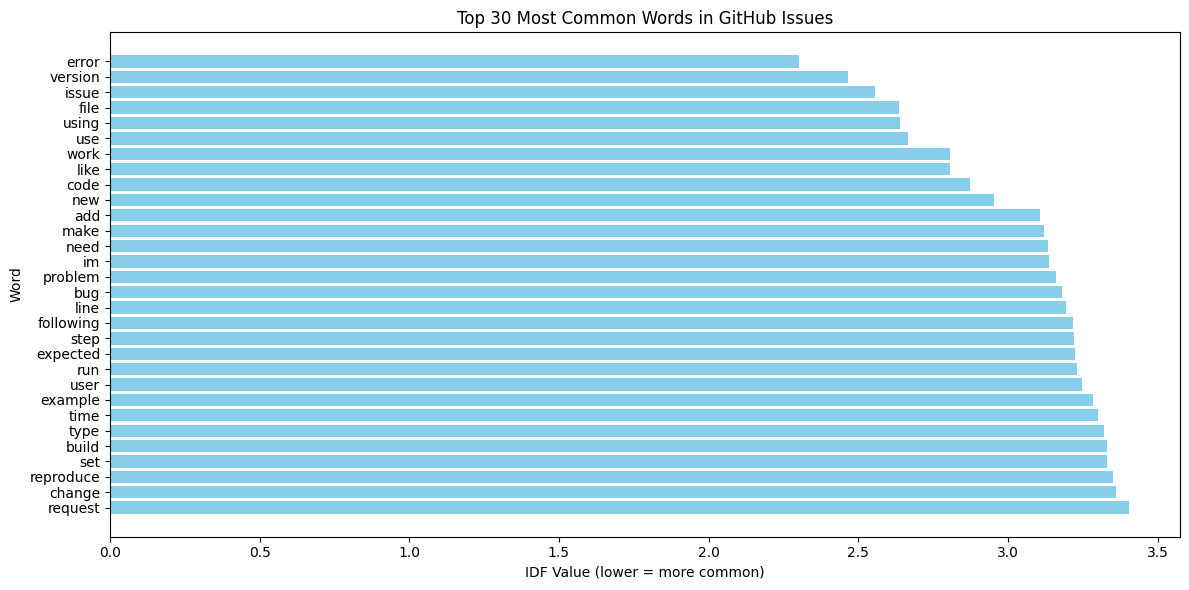

In [60]:
top_common = common_words.head(30)

plt.figure(figsize=(12, 6))
plt.barh(top_common['word'], top_common['idf'], color='skyblue')
plt.xlabel('IDF Value (lower = more common)')
plt.ylabel('Word')
plt.title('Top 30 Most Common Words in GitHub Issues')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [61]:
sample_df = processed_df.copy()

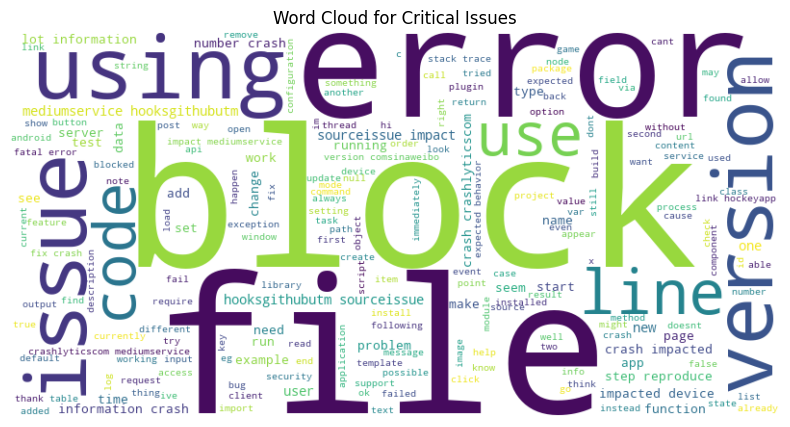

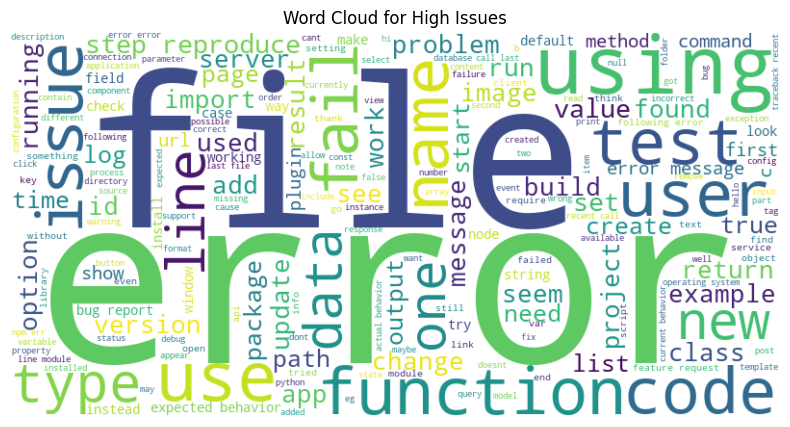

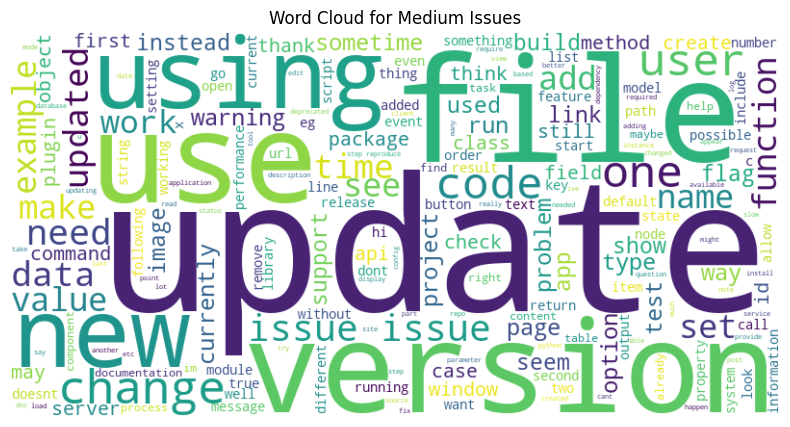

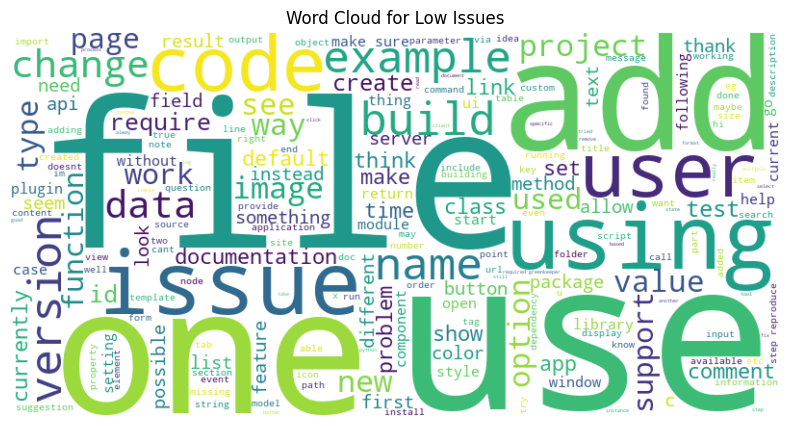

In [62]:
for priority in ['Critical', 'High', 'Medium', 'Low']:
  text = " ".join(sample_df[sample_df['priority']==priority]['clean_text'].tolist())
  wc = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(10,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for {priority} Issues")
  plt.show()

## Analysis: Word Clouds by Priority

Word clouds provide a visual summary of the most frequent words in issue descriptions for each priority level. They help highlight the keywords that are most associated with different types of bugs:

- **Critical Issues:** `error`, `block`, `file`, `issue`, `version`
  - These words suggest that critical issues often involve blocking errors, inaccessible files, or version-related failures.

- **High Issues:** `error`, `file`, `using`, `version`, `name`
  - High-priority issues frequently mention errors and file usage, indicating problems that affect functionality but may not completely block the system.

- **Medium Issues:** `update`, `version`, `file`, `use`, `new`
  - Medium-priority issues often relate to updates, new features, or version changes that are important but not urgent.

- **Low Issues:**  `add`, `use`, `file`, `issue`, `build`
  - Low-priority issues tend to involve minor enhancements, additions, or general maintenance tasks.

**Interpretation:**
The word clouds show clear patterns in language across priority levels. Critical and high issues are dominated by words reflecting system failures and errors, whereas medium and low issues involve more routine updates or feature-related terminology. This aligns with expectations and supports the validity of the weak supervision labeling approach.

In [63]:
def count_keywords(text, keywords):
  text = str(text).lower()
  return sum(1 for word in keywords if word in text)

In [64]:
# Flatten all keywords from heuristic priority dictionary
all_priority_keywords = [
  "crash", "urgent", "block", "security", "data loss", "leak", "fail",
  "error", "timeout", "slow", "warning", "minor", "typo", "cosmetic", "enhancement"
]

In [65]:
# Create numeric features
sample_df["word_count"] = sample_df["clean_text"].apply(lambda x: len(x.split()))
sample_df["keyword_count"] = sample_df["clean_text"].apply(lambda x: count_keywords(x, all_priority_keywords))
sample_df["avg_word_length"] = sample_df["clean_text"].apply(
  lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
)

# Encode priorities numerically for correlation
priority_map = {"Critical": 3, "High": 2, "Medium": 1, "Low": 0}
sample_df["priority_encoded"] = sample_df["priority"].map(priority_map)

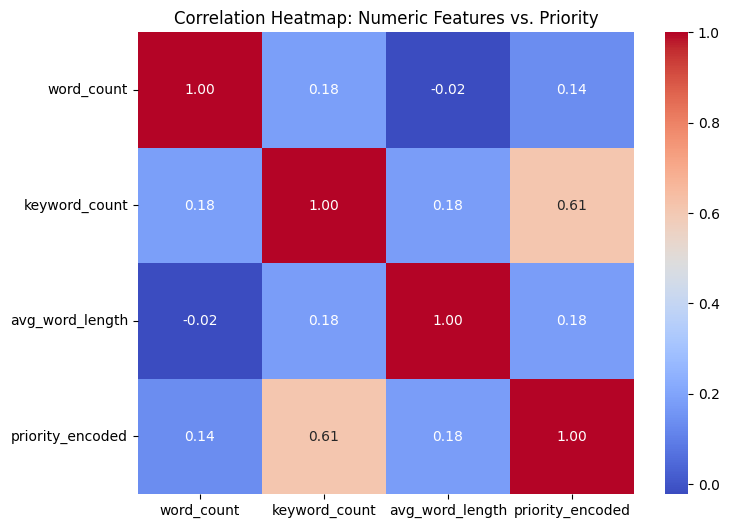

In [66]:
# Correlation matrix
corr_features = ["word_count", "keyword_count", "avg_word_length", "priority_encoded"]
corr_matrix = sample_df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Numeric Features vs. Priority")
plt.show()

## Analysis: Correlation Heatmap of Numeric Features

To explore how numeric features relate to the assignment priority, I created a correlation matrix using the following features:

- **`keyword_count`:** number of priority-related keywords in the issue.
- **`word_count`:** total number of words in the ticket.
- **`avg_word_length`:** average word length, capturing textual complexity.
- **`priority_encoded`:** numeric encoding of priority levels (Low=0, Medium=1, High=2, Critical=3)

### Observed correlations

| Feature Pair | Correlation | Interpretation |
| - | - | - |
| `priority_encoded` / `keyword_count` | 0.61 | Strong positive correlation; tickets with more priority-related keywords are more likely to be high or critical priority. |
| `priority_encoded` / `word_count` | 0.14 | Weak positive correlation; longer tickets are slightly more likely to have higher priority. |
| `priority_encoded` / `avg_word_length` | 0.18 | Weak positive correlation; tickets with longer words show a small tendency to have higher priority. |

### Conclusion

1. **`keyword_count` is the strongest predictor** of priority, reflecting the design of the weak supervised labeling system.
2. **`word_count` and `avg_word_length` add subtle nuance**, capturing ticket length and text complexity without introducing redundancy.
3. **Feature independence is good**, as low correlations between numeric features indicate that each contributes unique information to the model.

Overall, this correlation analysis confirms that the chosen numeric features are appropriate for inclusion in the predictive model and provide complementary perspectives on ticket content.

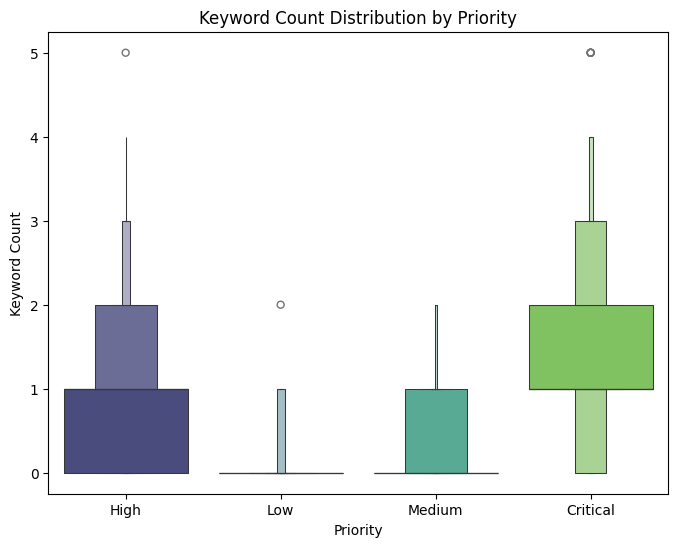

In [67]:
# Boxenplot: Distribution of keywords per priority level
plt.figure(figsize=(8, 6))
sns.boxenplot(
  data=sample_df,
  x="priority",
  y="keyword_count",
  palette="viridis",
  hue="priority"
)

plt.title("Keyword Count Distribution by Priority")
plt.ylabel("Keyword Count")
plt.xlabel("Priority")
plt.show()

## Analysis: Keyword Count Distribution by Priority

The boxen plot shows the distribution of `keyword_count` for each priority level:

- **Critical Issues:**
  - Highest median keyword count and largest upper quartile values.
  - Indicates that tickest flagged as critical contain more prioirity-related keywords, aligning with expectations.

- **High Issues:**
  - Slightly lower median keyword count than critical, but still higher than Medium and Low priorities.
  - Suggests that keyword frequency is a strong signal for identifying high-priority issues.

- **Medium Issues:**
  - Moderate keyword count, with a wider interquartile range.
  - Reflects veriability in language for tickets that are not urgent but still important.

- **Low Issues:**
  - Lowest median keyword count and generally smaller spread.
  -  Many tickets contain few or no priority keywords, consistent with minor or non-urgent issues.

### Conclusion

1. **Keyword count is strongly associated with priority**, confirming its role as the primary of weak supervised labeling.
2. **Distributions overlap slightly**, particularly between Medium and High issues, highlighting that keyword count alone may not perfectly separate all priority levels.
3. **Boxen plot advantages:** By showing the full distribution including tails, it highlights outliers (e.g., Critical issues with unusually low keyword counts or low tickets with unexpectedly high counts) that may warrant further investigation.

In [68]:
processed_df.shape

(38166, 4)

In [69]:
processed_df.columns

Index(['issue_title', 'body', 'clean_text', 'priority'], dtype='object')

In [70]:
processed_df.head()

,issue_title,body,clean_text,priority
1,long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...,long string input commandline fail long string input commandline cause failure string long filename truncate text long input creating filename add option specify filename,High
2,raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...,raster simulation rendering lw4 raster displaysimulate quirk lw4 huge improvement lw3 appreciative volunteer work gone contribute code paid nothing use program right criticism therefore intended c...,Low
4,first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_...",first reading adc without adc start adc temperaturecpp temperaturecpp version 11x 20 fuction void temperatureisr static adcsensorstate adc sensor state startupdelay cpp switch adc sensor state tem...,Medium
7,retrieve any bookings for a specific customer id,"use case as a concierge, i want to retrieve any bookings for a specific customer id so that i can view any bookings under this customer, if there are any conditions of acceptance - i enter valid c...",retrieve booking specific customer id use case concierge want retrieve booking specific customer id view booking customer condition acceptance enter valid customer id get list booking descending c...,High
10,does not recognise the bucket name,"i am using django-s3-storage==0.11.2 and boto3==1.4.4. these are in the settings.py: static_url = '/static/' staticfiles_dirs = os.path.join base_dir, static , static_root = os.path.join base_dir,...",recognise bucket name using djangos3storage0112 boto3144 settingspy static url static staticfiles dirs ospathjoin base dir static static root ospathjoin base dir static cdn medium url medium mediu...,High


In [71]:
X.shape

(38166, 10000)

In [72]:
y.shape

(38166,)

In [73]:
y.isna().sum()

np.int64(0)

## Save Processed Data

In [74]:
joblib.dump(processed_df, '../../data/processed/processed_github_issues_df.joblib')
print("Processed DataFrame saved successfully!")

Processed DataFrame saved successfully!


In [75]:
loaded_df = joblib.load('../../data/processed/processed_github_issues_df.joblib')
loaded_df.head()

,issue_title,body,clean_text,priority
1,long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...,long string input commandline fail long string input commandline cause failure string long filename truncate text long input creating filename add option specify filename,High
2,raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...,raster simulation rendering lw4 raster displaysimulate quirk lw4 huge improvement lw3 appreciative volunteer work gone contribute code paid nothing use program right criticism therefore intended c...,Low
4,first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_...",first reading adc without adc start adc temperaturecpp temperaturecpp version 11x 20 fuction void temperatureisr static adcsensorstate adc sensor state startupdelay cpp switch adc sensor state tem...,Medium
7,retrieve any bookings for a specific customer id,"use case as a concierge, i want to retrieve any bookings for a specific customer id so that i can view any bookings under this customer, if there are any conditions of acceptance - i enter valid c...",retrieve booking specific customer id use case concierge want retrieve booking specific customer id view booking customer condition acceptance enter valid customer id get list booking descending c...,High
10,does not recognise the bucket name,"i am using django-s3-storage==0.11.2 and boto3==1.4.4. these are in the settings.py: static_url = '/static/' staticfiles_dirs = os.path.join base_dir, static , static_root = os.path.join base_dir,...",recognise bucket name using djangos3storage0112 boto3144 settingspy static url static staticfiles dirs ospathjoin base dir static static root ospathjoin base dir static cdn medium url medium mediu...,High


In [76]:
joblib.dump(X, '../../data/processed/tfidf/X_tfidf.joblib')
joblib.dump(y, '../../data/processed/tfidf/y_labels.joblib')
joblib.dump(v, '../../data/processed/tfidf/fitted_vectorizer.joblib')
print("TF-IDF matrix, labels, and vectorizer saved successfully!")

TF-IDF matrix, labels, and vectorizer saved successfully!
